In [ ]:
#!pip install tensorflow

In [1]:
# import packages

import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten , Dense, Activation,Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization

from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
# delays between contact licometer and video

#090419
# mouse1 = 96.5 seconds

In [39]:
# NOTE: RNN model of course works better when it can overfit to 1 session

sessNames = []
#sessNames.append('207R_090419')
sessNames.append('207RR_090419')
#sessNames.append('207LL_090419')
#sessNames.append('366L_090419')
#sessNames.append('366B_090419')
sessNames.append('367B_090419')

delays = []    # time (s) video recorded before licometer program began
#delays.append(16.5)
delays.append(15.5)
#delays.append(9.3)
#delays.append(6.3)
#delays.append(12)
delays.append(14.5)

In [40]:
    
    
masterMat = np.empty([len(sessNames)*30000,20,20])    
masterLicks = np.empty([len(sessNames)*30000,])

for vidIDX in range(0,len(sessNames)):
    
    # read in licometer data and turn into target bins
    temp_df = pd.read_csv(sessNames[vidIDX]+'.csv',header=None)

    # first reward is always at exactly 80 seconds (according to contact licometer)

    temp1 = temp_df.values
    temp1 = temp1[temp1[:,0]==1,1]
    temp1 = temp1/1000   # convert from millisecs to secs
    temp1 = temp1 + delays[vidIDX] # time diff between video and licometer
    temp1 = np.round(temp1*16.6666).astype(int)
    #temp1 = np.floor(temp1).astype(int)

    #print(temp_df.shape)
    #print(temp1.shape)

    #temp1

    videoMat = np.load(sessNames[vidIDX]+'.npy')
    videoMat.shape

    # downsample 16.666 FPS to 1 bin per second
#    binFlag = np.array(range(0,len(videoMat)))+1
#    binFlag = binFlag/16.6666
#    binFlag = np.floor(binFlag).astype(int)

#    binMat = np.empty([max(binFlag),100,100])

#    for binIDX in range(0,max(binFlag)):

#        tempSlice = videoMat[binFlag==binIDX,:,:]

#        binMat[binIDX,:,:] = np.mean(tempSlice,axis=0)


    binMat = videoMat
        
    lickTarget = np.zeros([len(binMat),])
    lickTarget[temp1] = 1
    lickTarget[temp1+1] = 1
    #lickTarget[temp1+2] = 1
    lickTarget[temp1-1] = 1
    lickTarget.shape

    # limit to the 30 min session
    lickTarget = lickTarget[0:30000]
    binMat = binMat[0:30000,:,:]
    
    downMat = np.empty([len(binMat),20,20])

    for Frame in range(0,len(binMat)):

        downMat[Frame] = downscale_local_mean(binMat[Frame], (5, 5))

    zMat = (downMat - np.mean(downMat,axis=0)) / np.std(downMat,axis=0)
    #zMat = downMat
    
    # append session bins to master matrix
    masterLicks[vidIDX*30000:(vidIDX+1)*30000] = lickTarget
    masterMat[vidIDX*30000:(vidIDX+1)*30000,:,:] = zMat
    
    print('percent licking frames')
    print(np.sum(lickTarget)/len(lickTarget))
    
    
del videoMat
del binMat

percent licking frames
0.0621
percent licking frames
0.10846666666666667


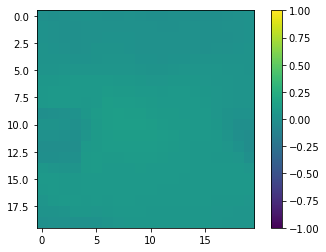

In [30]:
# Plot mean of all z scored frames when animal NOT licking
plt.figure()
plt.imshow(np.mean(masterMat[masterLicks==0,:,:],axis=0),vmin=-1, vmax=1)
plt.colorbar()
plt.grid(False)
plt.show()

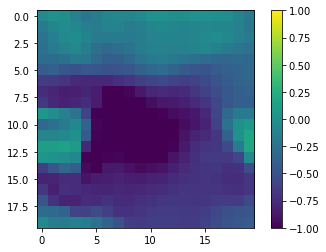

In [31]:
# Plot mean of all z scored frames when animal licking
plt.figure()
plt.imshow(np.mean(masterMat[masterLicks==1,:,:],axis=0),vmin=-1, vmax=1)
plt.colorbar()
plt.grid(False)
plt.show()

In [32]:
# reshape x_smote and x_test
X_2dim = masterMat.reshape([len(masterMat),400])


In [33]:
# For each timestep, create a 2D matrix of historical values (for training data)
x_smote_num = X_2dim #.values
y_smote_num = masterLicks #.values
#y_smote_num[y_smote_num==-1] = 0

timewindow = 10

steps = range(5,x_smote_num.shape[0]-5)

x_train_steps = np.zeros([len(steps),timewindow,x_smote_num.shape[1]])

y_train_steps = np.zeros(len(steps))

for timestep in steps:
    
    step_history = x_smote_num[range(timestep-5,timestep+5),:]
    
    x_train_steps[timestep-5,:,:] = step_history

    y_train_steps[timestep-5] = y_smote_num[timestep]
    

In [34]:
x_train_steps.shape

(59990, 10, 400)

In [35]:
# Split data into training versus testing
from sklearn.model_selection import train_test_split

#zMat = (zMat - np.min(zMat))/(np.max(zMat) - np.min(zMat))
#zMat = zMat.reshape(zMat.shape[0], 20, 20, 1)

# Separate Features from Target
#X = x_train_steps   # load features into X DF
#Y = masterLicks   # Load target into Y DF

# split into a training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(x_train_steps, y_train_steps, test_size=0.2, random_state=1)


In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation


model2 = keras.models.Sequential()
model2.add(keras.layers.LSTM(10,activation='relu',input_shape=x_train_steps.shape[-2:]))
model2.add(Dropout(0.1))
model2.add(Dense(32, input_shape=(10,),activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(1, input_shape=(32,)))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.metrics_names)

#print(model.summary())

#### use randomized target array as control
#y_train_steps = np.array([random.randint(0, 1) for p in range(0, len(y_train_steps))])

batch_size = 10
epochs = 3

history = model2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score = model2.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

[]
Epoch 1/3
4320/4320 [==============================] - 13s 3ms/step - loss: 0.2026 - accuracy: 0.9254 - val_loss: 0.1769 - val_accuracy: 0.9325
Epoch 2/3
4320/4320 [==============================] - 13s 3ms/step - loss: 0.1590 - accuracy: 0.9366 - val_loss: 0.1533 - val_accuracy: 0.9344
Epoch 3/3
1200/1200 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.94 - 2s 1ms/step - loss: 0.1478 - accuracy: 0.9447
Test loss: 0.14782151579856873
Test accuracy: 0.9446574449539185


In [37]:
from sklearn.metrics import confusion_matrix

y_pred = model2.predict(X_test)
y_pred[y_pred>np.percentile(y_pred,90)] = 1
y_pred = np.round(y_pred)

pd.DataFrame(
    confusion_matrix(y_test,y_pred),
    columns=['Predicted No Lick', 'Predicted Lick'],
    index=['True No Lick', 'True Lick']
)

,Predicted No Lick,Predicted Lick
True No Lick,10510,495
True Lick,288,705


<Figure size 432x288 with 0 Axes>

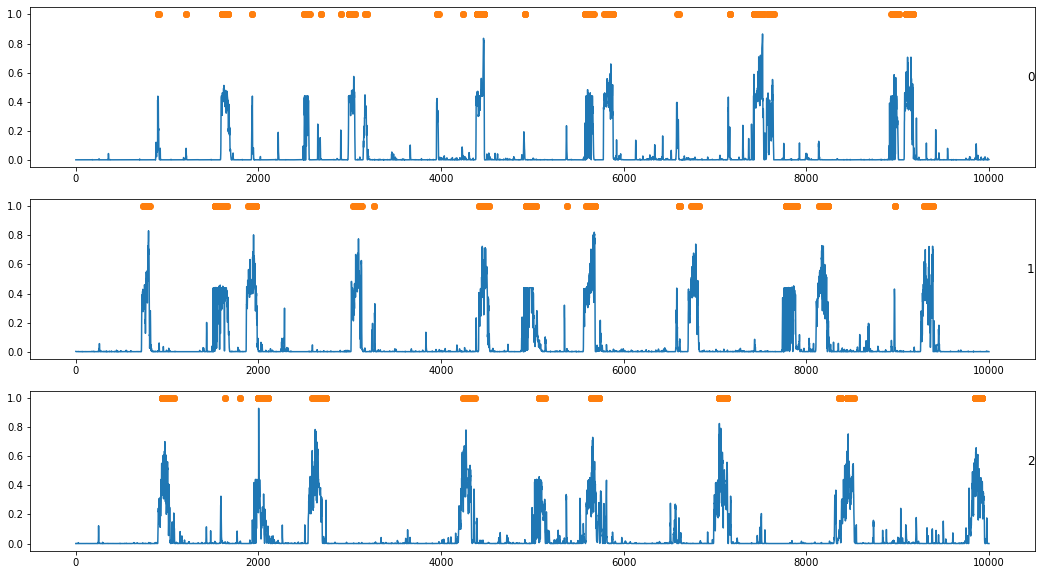

In [38]:
## plot the prediction of frames and the real target

plt.figure()
fig,ax = plt.subplots(figsize=(18,10))

#epochCNT = int((len(x_train_steps)/10000))
epochCNT = 3

for frameEpoch in range(0,epochCNT):

    y_pred = model2.predict(x_train_steps[10000*frameEpoch:10000*(frameEpoch+1)])
    y_true = y_train_steps[10000*frameEpoch:10000*(frameEpoch+1)]

    xtics = np.array(range(0,y_true.shape[0]))

    # generate markers for behavioral timestamps
    eventFlags = xtics[y_true==1]
    yposFlags = 1*np.ones(eventFlags.shape)

    # plot timeseries for each cell, with the cell source ID included

    plt.subplot(epochCNT, 1, frameEpoch+1)

    plt.plot(xtics,y_pred)
    plt.plot(eventFlags,yposFlags,'o')
    plt.title(frameEpoch, y=0.5, loc='right')

plt.show()

# Orange dots represent real licks (contact licometer circuit triggered)
# Blue represents model predict score of video frame

from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

#### returns a compiled model
#### identical to the previous one
model = load_model('my_model.h5')

import cv2
import numpy as np
import scipy.ndimage


subMat = masterMat[1100:1300,:,:]
subMat = (subMat - np.min(subMat))/(np.max(subMat)-np.min(subMat))

subLicks = masterLicks[1100:1300]

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')

writer = cv2.VideoWriter('test2.avi', fourcc, 5, (300, 300))

for idx in range(0,len(subMat)):
    gray = subMat[idx,:,:]
    gray = scipy.ndimage.zoom(gray, 15, order=0)
    
    if subLicks[idx] == 1:
    
        gray[:10,:]  = 0
        gray[-10:,:] = 0
        gray[:,:10]  = 0
        gray[:,-10:] = 0
    
    #gray = gray[0:144,0:256]
    gray = cv2.normalize(gray, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    #gray_3c = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
    gray_3c = cv2.merge([gray, gray, gray])
    
    writer.write(gray_3c)
    
writer.release()    